In [40]:
import os
import logging
import traceback
import pandas as pd
from collections import defaultdict
from GCP.lib.model.GCP_Model import GCP_Model
from IPython.display import display, Image as IPImage
from GCP.lib.prompts.text_block_evaluate import create_chain_evaluation
from GCP.lib.prompts.img_to_text import transcriber_job_description_prompt, image_summary_transcriber_prompt

filename = 'C:\\Agentes-RAG\\GCP-Credentials\\llms-433815-5e7ca2a0c045.json'

In [3]:
# Configuración del logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # Usar DEBUG para capturar todos los niveles de logs

# Crear un manejador de archivos que registre todos los mensajes
file_handler = logging.FileHandler('./Agregar_Metadatos.log')
file_handler.setLevel(logging.DEBUG)

# Crear un formato de registro que incluya hora con milisegundos y nombre del logger
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Agregar el manejador de archivos al logger
logger.addHandler(file_handler)

In [4]:
# Definición de las rutas base y el nombre del documento
base_unstruced_img = '../../unstructured/project/NoteBooks'
base_unstruced_data = '../../unstructured/project/NoteBooks/data'
document_name = 'Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks.pdf'

# Registro de la configuración inicial
logger.debug("Base image path: %s", base_unstruced_img)
logger.debug("Base data path: %s", base_unstruced_data)
logger.debug("Document name: %s", document_name)

# Carga del DataFrame a partir del archivo CSV
csv_path = os.path.join(base_unstruced_data, 'raw', document_name + '.csv')
logger.debug("Attempting to load CSV from: %s", csv_path)

try:
    df_unstructured = pd.read_csv(csv_path, index_col=0)
    logger.debug("CSV loaded successfully, shape: %s", df_unstructured.shape)
except Exception as e:
    logger.error("Failed to load CSV from %s: %s", csv_path, e)
    df_unstructured = None

# Lectura del archivo JSON con la meta información del documento
json_path = os.path.join(base_unstruced_data, 'meta', document_name + '.json')
logger.debug("Attempting to load JSON metadata from: %s", json_path)

try:
    with open(json_path, 'r') as archivo:
        document_meta_info = archivo.read()
        logger.debug("JSON metadata loaded successfully")
except Exception as e:
    logger.error("Failed to load JSON metadata from %s: %s", json_path, e)
    document_meta_info = ""


In [5]:
# Instancia del modelo Gemini
logger.debug("Attempting to instantiate Gemini model with name: 'gemini-1.5-pro-001'")
try:
    gemini_model = GCP_Model(
        model_name="gemini-1.5-pro-001",
        credentials_path='C:\\Agentes-RAG\\GCP-Credentials\\llms-433815-5e7ca2a0c045.json'
    )
    logger.debug("Gemini model instantiated successfully")
except Exception as e:
    logger.error("Failed to instantiate Gemini model: %s", e)
    gemini_model = None

# Instancia del modelo Llama
logger.debug("Attempting to instantiate Llama model with name: 'publishers/meta/models/llama3-405b-instruct-maas'")
try:
    llama_model = GCP_Model(model_name="publishers/meta/models/llama3-405b-instruct-maas")
    logger.debug("Llama model instantiated successfully")
except Exception as e:
    logger.error("Failed to instantiate Llama model: %s", e)
    llama_model = None

# Creación de la cadena de evaluación para Gemini
logger.debug("Attempting to create evaluation chain for Gemini model")
try:
    gemini_eval_chain = create_chain_evaluation(gemini_model, document_meta_info)
    logger.debug("Evaluation chain for Gemini model created successfully")
except Exception as e:
    logger.error("Failed to create evaluation chain for Gemini model: %s", e)
    gemini_eval_chain = None

# Creación de la cadena de evaluación para Llama
logger.debug("Attempting to create evaluation chain for Llama model")
try:
    llama_eval_chain = create_chain_evaluation(llama_model, document_meta_info)
    logger.debug("Evaluation chain for Llama model created successfully")
except Exception as e:
    logger.error("Failed to create evaluation chain for Llama model: %s", e)
    llama_eval_chain = None


In [6]:
logger.debug("Inicio de pruebas de funcionamiento de clasificación de un bloque")
example_row = {
    "text_to_evaluate": 'An example of a small application that you can create using LangChain on Vertex AI is one that returns the exchange rate between two currencies on a specified date.',
    "old_type": 'NarrativeText',
    'next_block': 'None'}

print('# GEMINI 1.5 Pro\n', gemini_eval_chain.invoke(example_row))
print('\n# LLaMa 3.1 405b\n', llama_eval_chain.invoke(example_row))


# GEMINI 1.5 Pro
 {'makes_sense': True, 'block_type': 'NarrativeText', 'description': 'Describes a potential small application using LangChain on Vertex AI for currency exchange rate retrieval.'}

# LLaMa 3.1 405b
 {'makes_sense': True, 'block_type': 'NarrativeText', 'description': 'This text block describes an example application of LangChain on Vertex AI, specifically one that returns the exchange rate between two currencies on a specified date.'}


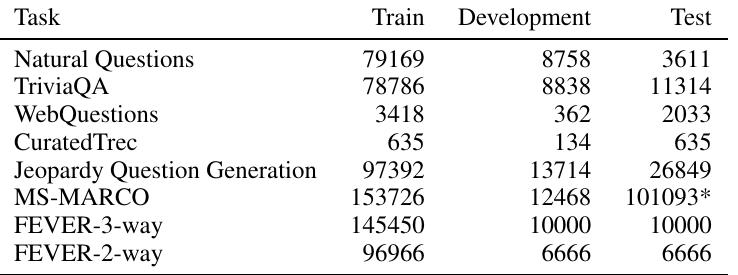

| Task | Train | Development | Test |
|---|---|---|---|
| Natural Questions | 79169 | 8758 | 3611 |
| TriviaQA | 78786 | 8838 | 11314 |
| WebQuestions | 3418 | 362 | 2033 |
| CuratedTrec | 635 | 134 | 635 |
| Jeopardy Question Generation | 97392 | 13714 | 26849 |
| MS-MARCO | 153726 | 12468 | 101093* |
| FEVER-3-way | 145450 | 10000 | 10000 |
| FEVER-2-way | 96966 | 6666 | 6666 | 


The table lists the number of questions used for training, development and testing in different question answering tasks. 

| Task | Train | Development | Test |
|---|---|---|---|
| Natural Questions | 79,169 | 8,758 | 3,611 |
| TriviaQA | 78,786 | 8,838 | 11,314 |
| WebQuestions | 3,418 | 362 | 2,033 |
| CuratedTrec | 635 | 134 | 635 |
| Jeopardy Question Generation | 97,392 | 13,714 | 26,849 |
| MS-MARCO | 153,726 | 12,468 | 101,093 |
| FEVER-3-way | 145,450 | 10,000 | 10,000 |
| FEVER-2-way | 96,966 | 6,666 | 6,666 |

MS-MARCO test set has over 100,000 questions, while most other sets have significantly 

In [15]:
logger.debug("Inicio de pruebas de funcionamiento de traducción de imagen de tabla")
img_path = os.path.join(base_unstruced_img, 'images', document_name, 'table-19-5.jpg')
display(IPImage(img_path))

print(gemini_model.invoke(transcriber_job_description_prompt, image_path=img_path))
print()
print(gemini_model.invoke(image_summary_transcriber_prompt, image_path=img_path))


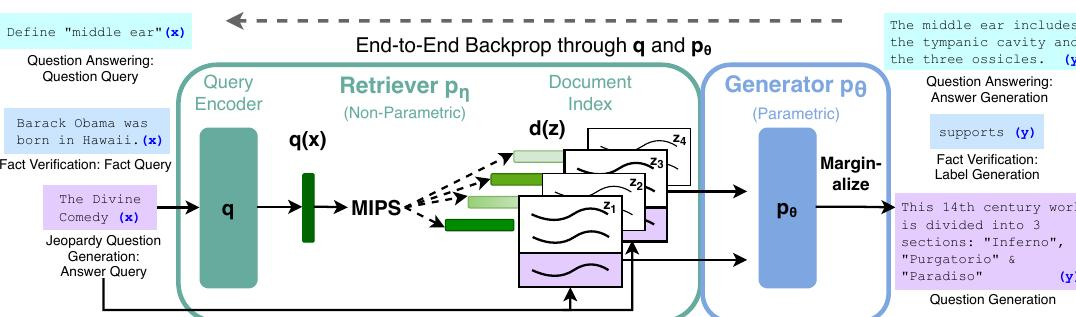

The image depicts a diagram outlining an end-to-end backpropagation process through components labeled 'q' and 'pe'. 

**Left Side (Green Boxes):**

* **Query Examples:** This section provides examples for different question answering tasks: 
    * Define "middle ear" (x) - Question Query
    * Barack Obama was born in Hawaii (x) - Fact Query
    * The Divine Comedy (x) - Fact Query (Jeopardy style)
* **Query Encoder:** A green box labeled "Query Encoder" receives the input query (represented by a right arrow).
* **q:** A green box labeled 'q' outputs a value 'q'. 
* **q(x):** A green rectangle connecting 'q' to 'MIPS' is labeled 'q(x)'.
* **MIPS:**  A green rectangle labeled 'MIPS' receives input from 'q(x)'. Dotted arrows connect 'MIPS' to the 'Document Index' suggesting a retrieval process.

**Center (Gray Boxes):**

* **Retriever pn (Non-Parametric):** This label sits above the 'Document Index'.
* **Document Index:** This section contains four stacked rectangular boxes representing

In [8]:
logger.debug("Inicio de pruebas de funcionamiento de descripción de imagen")
img_path = os.path.join(base_unstruced_img, 'images', document_name, 'figure-2-1.jpg')
display(IPImage(img_path))

print(gemini_model.invoke(transcriber_job_description_prompt, image_path=img_path))
print()
print(gemini_model.invoke(image_summary_transcriber_prompt, image_path=img_path))

In [7]:
# Agregar una columna con el siguiente bloque de texto
df_unstructured['next_block'] = df_unstructured['text'].shift(-1)

In [42]:
def reclasificar_bloque(serie):
    table_text = None
    image_description = None
    block_type_model = defaultdict(lambda: None)

    try:
        logger.debug("Processing series with type: {}".format(serie['type']))

        if serie['type'] == 'Table':
            logger.debug("Invoking gemini_model for Table type")
            table_text = gemini_model.invoke(
                transcriber_job_description_prompt,
                image_path=os.path.join(base_unstruced_img, serie['image_path'])
            )
            block_type_model['makes_sense'] = True
            block_type_model['block_type'] = 'Table'

        elif serie['type'] == 'Image':
            logger.debug("Invoking gemini_model for Image type")
            image_description = gemini_model.invoke(
                image_summary_transcriber_prompt,
                image_path=os.path.join(base_unstruced_img, serie['image_path'])
            )
            block_type_model['makes_sense'] = True
            block_type_model['block_type'] = 'Image'

        else:
            logger.debug("Evaluating block type using gemini_eval_chain")
            input_row = {
                "text_to_evaluate": serie['text'],
                "old_type": serie['type'],
                'next_block': serie['next_block']
            }
            block_type_model = gemini_eval_chain.invoke(input_row)

    except Exception as e:
        # Captura la traza completa del error
        error_message = ''.join(traceback.format_exception(None, e, e.__traceback__))

        # Loguear el error con la traza completa
        logger.error(f"An error occurred during classification: {e}\n{error_message}")

        # Imprimir el error en rojo
        print(f"\033[91mAn error occurred during classification: {e}\n{error_message}\033[0m")

    result = (
        block_type_model.get('makes_sense', None) if block_type_model else None,
        block_type_model.get('block_type', None) if block_type_model else None,
        block_type_model.get('description', None) if block_type_model else None,
        table_text,
        image_description
    )
    return result


# NO SE PUDO POR QUE HACE DEMACIADAS SOLICITUDES POR MINUTO Y EXEDE LA CUOTA DE SOLICITUDES POR MINUTO

# df_unstructured[['makes_sense', 'block_type', 'description', 'table_text', 'image_description']] = df_unstructured.apply(reclasificar, axis=1, result_type='expand')
import time

# Lista para almacenar los resultados
results = []

# Iterar sobre cada fila del DataFrame
for index, row in df_unstructured.iterrows():
    # Si el bloque ya tiene un tipo asignado, continuar con la siguiente fila
    if row['block_type'] is not None:
        continue

    # Ejecutar la función reclasificar para la fila actual
    result = reclasificar_bloque(row)

    # Añadir el resultado a la lista
    results.append(result)

    # Obtener el valor de 'block_type' del resultado
    block_type = result[1]  # Asumiendo que 'block_type' es el segundo elemento de la tupla

    # Log y print de la información
    logger.debug(f"Processed index {index}: block_type = {block_type}")
    print(f"Processed index {index}: block_type = {block_type}")

    # Agregar un retardo de 10 segundos
    time.sleep(10)

# Convertir los resultados en un DataFrame y asignar a las columnas respectivas
df_unstructured[['makes_sense', 'block_type', 'description', 'table_text', 'image_description']] = pd.DataFrame(results,
                                                                                                                index=df_unstructured.index)


Processed index 0: block_type = UncategorizedText
Processed index 1: block_type = UncategorizedText
Processed index 2: block_type = UncategorizedText
Processed index 3: block_type = Title
Processed index 4: block_type = Author Names
Processed index 5: block_type = Author Names
Processed index 6: block_type = Author Names
Processed index 7: block_type = UncategorizedText
Processed index 8: block_type = Title
Processed index 9: block_type = NarrativeText
Processed index 10: block_type = Title
Processed index 11: block_type = NarrativeText
Processed index 12: block_type = Image
Processed index 13: block_type = FigureCaption
Processed index 14: block_type = NarrativeText
Processed index 15: block_type = NarrativeText
Processed index 16: block_type = NarrativeText
Processed index 17: block_type = NarrativeText
Processed index 18: block_type = Title
Processed index 19: block_type = NarrativeText
Processed index 20: block_type = NarrativeText
Processed index 21: block_type = UncategorizedText

In [45]:
df_unstructured.to_csv('./data/Metadata/Bloques_y_tablas.csv')

In [18]:
import pandas as pd

df_unstructured = pd.read_csv('./data/Metadata/Bloques_y_tablas.csv', index_col=0)
df_cat = pd.read_csv('./data/Etiquetas-bloques-clasificacion-manual.csv', index_col=0, sep=';')
df = df_unstructured.join(df_cat, how='inner')
df

,type,element_id,text,coordinates_points,coordinates_system,coordinates_layout_width,coordinates_layout_height,last_modified,filetype,languages,...,detection_class_prob,parent_id,image_path,next_block,makes_sense,block_type,description,table_text,image_description,Clasificacion Mamual
0,UncategorizedText,2a79c74e7aacdeced6760e8e3a21a60e,1 2 0 2,"((45.388888888888886, 589.6111111111111), (45....",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,NaN,NaN,NaN,r p A 2 1 ] L C . s c [,False,UncategorizedText,The text block appears to be a random sequence...,NaN,NaN,UncategorizedText
1,Header,6afcf8d92b2e1513a713972102cd8216,r p A 2 1 ] L C . s c [,"((45.1381721496582, 688.5795288085938), (45.13...",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,0.515812,NaN,NaN,4 v 1 0 4 1 1 . 5 0 0 2 : v i X r a,False,UncategorizedText,The text block appears to be a random sequence...,NaN,NaN,UncategorizedText
2,UncategorizedText,3a8065e6efc332ca5cd4bf6950df8663,4 v 1 0 4 1 1 . 5 0 0 2 : v i X r a,"((45.388888888888886, 1094.1666666666665), (45...",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,NaN,6afcf8d92b2e1513a713972102cd8216,NaN,Retrieval-Augmented Generation for Knowledge-I...,False,UncategorizedText,The text block consists of a seemingly random ...,NaN,NaN,UncategorizedText
3,Title,683c711fcc9f2170bd2584bb150a2725,Retrieval-Augmented Generation for Knowledge-I...,"((463.0325927734375, 276.19338500000003), (463...",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,0.479248,6afcf8d92b2e1513a713972102cd8216,NaN,"Patrick Lewis'?, Ethan Perez*,",True,Title,The title of the research paper.,NaN,NaN,Title
4,NarrativeText,5549ff0886ea40db28c2e81555d860fb,"Patrick Lewis'?, Ethan Perez*,","((664.65380859375, 498.6003255555554), (664.65...",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,0.432448,683c711fcc9f2170bd2584bb150a2725,NaN,"Aleksandra Piktus†, Fabio Petroni†, Vladimir K...",True,Author Names,"Lists the names of authors, potentially with a...",NaN,NaN,Author Names
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,Title,8cc9db04a2f4cc220f257af592fffe8a,H Retrieval Collapse,"((297.9806823730469, 892.2873244444444), (297....",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,0.907250,NaN,NaN,"In preliminary experiments, we observed that f...",True,Title,This is a section title likely referring to a ...,NaN,NaN,Title
220,NarrativeText,2468b5236da66343df583c9d870c41f3,"In preliminary experiments, we observed that f...","((299.0027777777778, 961.0620044444444), (299....",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,0.947708,8cc9db04a2f4cc220f257af592fffe8a,NaN,I Number of instances per dataset,True,NarrativeText,This block discusses challenges encountered du...,NaN,NaN,NarrativeText
221,Title,7f10efb85a3fe1e47acc1d058e6c9591,I Number of instances per dataset,"((298.6259765625, 1217.178991111111), (298.625...",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,0.911698,NaN,NaN,"The number of training, development and test d...",True,Title,This is a section title likely referring to a ...,NaN,NaN,Title
222,NarrativeText,a3a2969e742677c71e137666dcca51ba,"The number of training, development and test d...","((299.14166666666665, 1285.9536711111111), (29...",PixelSpace,1700,2200,2024-08-18T17:06:27,application/pdf,['eng'],...,0.881191,7f10efb85a3fe1e47acc1d058e6c9591,NaN,19,True,NarrativeText,This sentence describes the content of Table 7...,NaN,NaN,NarrativeText


In [19]:
num_correctly_classified = (df['block_type'] == df['Clasificacion Mamual']).sum()
number_of_elements = df.shape[0]
porcentage_class = num_correctly_classified / number_of_elements
print(f'Porcentaje de clasificación: {round(porcentage_class * 100, 2)}%')

Porcentaje de clasificación: 97.32%


In [20]:
# Mostrar los bloque mal clasificados
df[df['block_type'] != df['Clasificacion Mamual']][['text', 'block_type', 'Clasificacion Mamual']]

,text,block_type,Clasificacion Mamual
96,FVR-3 FVR-2 Label Accuracy,NaN,UncategorizedText
116,References,Bibliography,Title
139,"A In S. Bengio, retrieve-and-edit H. Wallach, ...",UncategorizedText,Bibliography
197,B Human Evaluation,UncategorizedText,Title
203,2https://github.com/pytorch/fairseq 3https://g...,UncategorizedText,Bibliography
213,G Parameters,UncategorizedText,Title


In [21]:
df = df[df['Clasificacion Mamual'] != 'UncategorizedText'][
    ['Clasificacion Mamual', 'text', 'filetype', 'languages', 'page_number', 'filename', 'description', 'table_text',
     'image_description']]
df['text'] = df.apply(
    lambda x: x['text'] if x['Clasificacion Mamual'] not in ['Image', 'Table'] else x['table_text'] if pd.notna(
        x['table_text']) else x['image_description'],
    axis=1
)

In [22]:
df['table caption'] = df['text'].shift(1)
df['image caption'] = df['text'].shift(-1)


def description_figures(row):
    match row['Clasificacion Mamual']:
        case 'Table':
            return row['table caption']
        case 'Image':
            return row['image caption']
        case _:
            return row['description']


df['description'] = df.apply(description_figures, axis=1)
df.drop(columns=['table_text', 'image_description', 'table caption', 'image caption'], inplace=True)
df

,Clasificacion Mamual,text,filetype,languages,page_number,filename,description
3,Title,Retrieval-Augmented Generation for Knowledge-I...,application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,The title of the research paper.
4,Author Names,"Patrick Lewis'?, Ethan Perez*,",application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,"Lists the names of authors, potentially with a..."
5,Author Names,"Aleksandra Piktus†, Fabio Petroni†, Vladimir K...",application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,"Lists the names of authors, potentially affili..."
6,Author Names,"Mike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, ...",application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,Lists the authors of the research paper.
8,Title,Abstract,application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,The title of the document.
...,...,...,...,...,...,...,...
218,NarrativeText,"parameters. The best performing ""closed-book"" ...",application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This block discusses the performance of differ...
219,Title,H Retrieval Collapse,application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This is a section title likely referring to a ...
220,NarrativeText,"In preliminary experiments, we observed that f...",application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This block discusses challenges encountered du...
221,Title,I Number of instances per dataset,application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This is a section title likely referring to a ...


In [23]:
df = df.rename(columns={
    'Clasificacion Mamual': 'block_type',
    'filetype': 'file_type'
})

In [24]:
import os
import json
base_unstruced_img = '../../unstructured/project/NoteBooks'
base_unstruced_data = '../../unstructured/project/NoteBooks/data'
document_name = 'Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks.pdf'
json_path = os.path.join(base_unstruced_data, 'meta', document_name + '.json')

try:
    with open(json_path, 'r') as archivo:
        document_meta_info = archivo.read()
except Exception as e:
    document_meta_info = ""

document_meta = json.loads(document_meta_info)
document_meta['authors'] = ','.join(document_meta['authors'])
document_meta['research_lab'] = ','.join(document_meta['research_lab'])
document_meta

{'title': 'Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks',
 'authors': 'Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fabio Petroni,Vladimir Karpukhin,Naman Goyal,Heinrich KÃ¼ttler,Mike Lewis,Wen-tau Yih,Tim RocktÃ¤schel,Sebastian Riedel,Douwe Kiela',
 'research_lab': 'Facebook AI Research,University College London,New York University',
 'publication_year': 2020}

In [25]:
df['authors'] = document_meta['authors']
df['research_lab'] = document_meta['research_lab']
df['publication_year'] = document_meta['publication_year']
df['title'] = document_meta['title']
df

,block_type,text,file_type,languages,page_number,filename,description,authors,research_lab,publication_year,title
3,Title,Retrieval-Augmented Generation for Knowledge-I...,application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,The title of the research paper.,"Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
4,Author Names,"Patrick Lewis'?, Ethan Perez*,",application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,"Lists the names of authors, potentially with a...","Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
5,Author Names,"Aleksandra Piktus†, Fabio Petroni†, Vladimir K...",application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,"Lists the names of authors, potentially affili...","Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
6,Author Names,"Mike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, ...",application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,Lists the authors of the research paper.,"Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
8,Title,Abstract,application/pdf,['eng'],1,Retrieval-Augmented Generation for Knowledge-I...,The title of the document.,"Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
...,...,...,...,...,...,...,...,...,...,...,...
218,NarrativeText,"parameters. The best performing ""closed-book"" ...",application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This block discusses the performance of differ...,"Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
219,Title,H Retrieval Collapse,application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This is a section title likely referring to a ...,"Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
220,NarrativeText,"In preliminary experiments, we observed that f...",application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This block discusses challenges encountered du...,"Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...
221,Title,I Number of instances per dataset,application/pdf,['eng'],19,Retrieval-Augmented Generation for Knowledge-I...,This is a section title likely referring to a ...,"Patrick Lewis,Ethan Perez,Aleksandra Piktus,Fa...","Facebook AI Research,University College London...",2020,Retrieval-Augmented Generation for Knowledge-I...


In [26]:
df.to_csv(f'./data/Metadata/Bloques_y_tablas_v2-{document_meta['title']}.csv')